In [1]:
import plotly.express as px
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2 # For image operations
import random # for shuffling
from matplotlib import pyplot as plt, cm
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
dataset_path = 'kvasir-dataset'
classes = ['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis',
           'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis']

In [3]:
class_images = {class_name: [] for class_name in classes}

In [4]:
def load_images_from_folder(class_name, n=500, image_size=(224, 224)):
    folder_path = os.path.join(dataset_path, class_name)
    images = []
    # Get the list of image file names
    filenames = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path)]
    # Load the images
    for filename in tqdm(filenames[:n], desc=f'Loading {class_name}'):
        img = cv2.imread(filename)  # By default, OpenCV reads images in BGR format
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB format
        img = cv2.resize(img, image_size)
        img = img / 255.0  # Normalizing the image
        images.append(img)  # Do not flatten
    return images

In [5]:
for class_name in classes:
    class_images[class_name] = load_images_from_folder(class_name)

Loading ulcerative-colitis: 100%|██████████| 500/500 [00:04<00:00, 116.14it/s]


In [6]:
dyed_lifted_polyps = class_images['dyed-lifted-polyps']
dyed_resection_margins = class_images['dyed-resection-margins']
esophagitis=class_images['esophagitis']
normal_cecum=class_images['normal-cecum']
normal_pylorus=class_images['normal-pylorus']
normal_z_line=class_images['normal-z-line']
polyps=class_images['polyps']
ulcerative_colitis=class_images['ulcerative-colitis']

In [7]:
np.random.seed(150) # Random seed to control the randomness of generated values
data = np.array(dyed_lifted_polyps + dyed_resection_margins + esophagitis + normal_cecum  + normal_pylorus + normal_z_line + polyps + ulcerative_colitis)  # Combining the list of images
labels = np.array([0]*500 + [1]*500 +[2]*500 +[3]*500 +[4]*500 +[5]*500 +[6]*500 +[7]*500) # creating class labels for the image classes
length = data.shape[0] # length of the data

# Shuffling the data and labels
indx = np.arange(length)
np.random.shuffle(indx)

data = data[indx]
labels = labels[indx]


In [8]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, random_state=150, test_size=0.3, stratify=labels, shuffle=True)

In [19]:
y_train= to_categorical(y_train, num_classes=8)
y_test = to_categorical(y_test, num_classes=8)

In [20]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [21]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

In [22]:
number_of_classes = 8

# Create the model
model_mobileNet = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(number_of_classes, activation='softmax')  # Final layer with softmax activation for 'n' classes
])

In [23]:
model_mobileNet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_2  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 256)               262400    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 3493320 (13.33 MB)
Trainable params: 264

In [24]:
model_mobileNet.compile(optimizer=Adam(lr=1e-5),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

In [25]:
history_mobileNet = model_mobileNet.fit(X_train, y_train,
                                        batch_size=32,
                                        epochs=10,  # Adjust number of epochs as necessary
                                        validation_data=(X_test, y_test))



Epoch 1/10



88/88 [==============================] - 43s 466ms/step - loss: 0.8912 - accuracy: 0.6621 - val_loss: 0.4924 - val_accuracy: 0.8300
Epoch 2/10
88/88 [==============================] - 37s 427ms/step - loss: 0.4571 - accuracy: 0.8186 - val_loss: 0.4134 - val_accuracy: 0.8292
Epoch 3/10
88/88 [==============================] - 31s 352ms/step - loss: 0.3645 - accuracy: 0.8539 - val_loss: 0.3306 - val_accuracy: 0.8725
Epoch 4/10
88/88 [==============================] - 31s 355ms/step - loss: 0.3339 - accuracy: 0.8654 - val_loss: 0.3527 - val_accuracy: 0.8675
Epoch 5/10
88/88 [==============================] - 31s 354ms/step - loss: 0.2881 - accuracy: 0.8864 - val_loss: 0.3184 - val_accuracy: 0.8767
Epoch 6/10
88/88 [==============================] - 33s 375ms/step - loss: 0.2440 - accuracy: 0.9079 - val_loss: 0.3148 - val_accuracy: 0.8800
Epoch 7/10
88/88 [==============================] - 34s 392ms/step - loss: 0.2348 - accuracy: 0.9093 - val_loss: 0.3042 - val_accuracy: 0.8775
Epoch 8/10

In [26]:
test_loss, test_accuracy = model_mobileNet.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')

38/38 [==============================] - 11s 275ms/step - loss: 0.3149 - accuracy: 0.8767
Test Accuracy: 0.8766666650772095


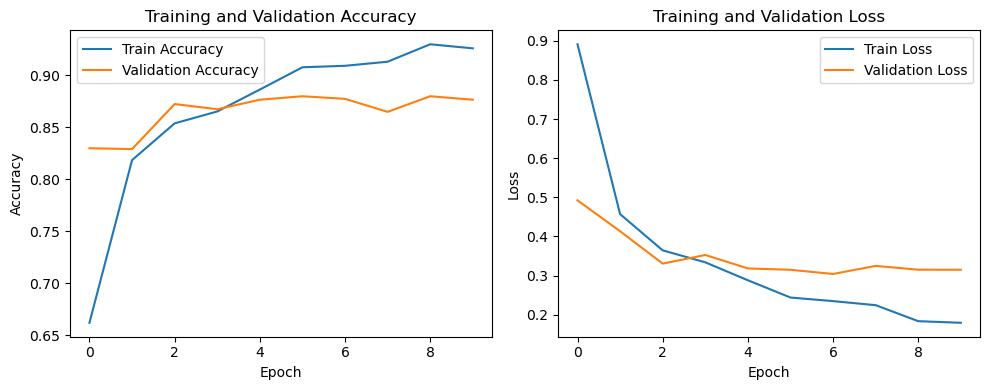

In [29]:
plt.figure(figsize=(10, 4))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_mobileNet.history['accuracy'], label='Train Accuracy')
plt.plot(history_mobileNet.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_mobileNet.history['loss'], label='Train Loss')
plt.plot(history_mobileNet.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [30]:
y_pred_proba_mobileNet = model_mobileNet.predict(X_test)
y_pred_mobileNet = np.argmax(y_pred_proba_mobileNet, axis=1)
y_true_mobileNet = np.argmax(y_test, axis=1)

38/38 [==============================] - 11s 282ms/step


In [31]:
precision_mobileNet = precision_score(y_true_mobileNet, y_pred_mobileNet, average='macro')
recall_mobileNet = recall_score(y_true_mobileNet, y_pred_mobileNet, average='macro')

print(f'Precision (MobileNet): {precision_mobileNet}')
print(f'Recall (MobileNet): {recall_mobileNet}')

Precision (MobileNet): 0.8776335932077083
Recall (MobileNet): 0.8766666666666667


38/38 [==============================] - 11s 278ms/step


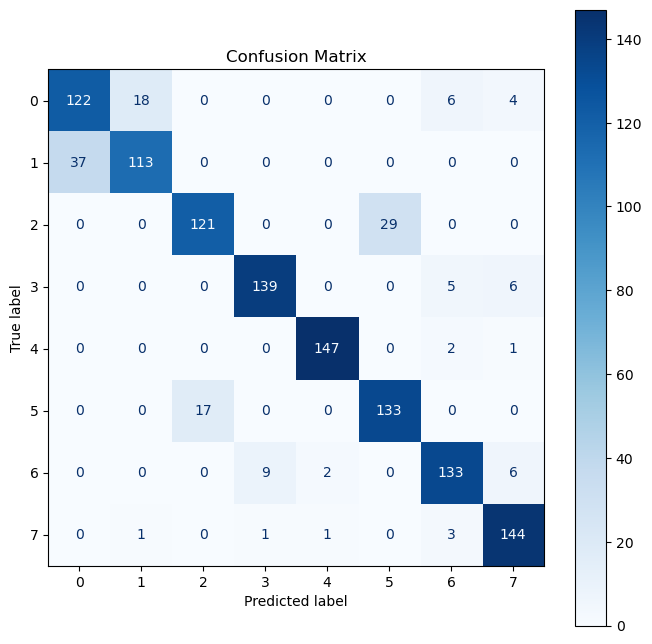

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions_prob = model_mobileNet.predict(X_test)
predictions = np.argmax(predictions_prob, axis=1)

# If your y_test labels are one-hot encoded, convert them back to class labels
y_test_labels = np.argmax(y_test, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test_labels, predictions)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))  # Adjust size as needed
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, ax=ax)  # You can change the colormap as you like
ax.set_title('Confusion Matrix')
plt.show()